<a href="https://colab.research.google.com/github/thyllmuller/AIML1-Project/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS986 Fundamentals Of Machine Learning For Data Analytics (Group1)

## Initial Data Processing

We begin by installing and importing relevant packages, hereafter we import the data for the Regression problem and make sure that any missing values are removed whilst we create initial train & test splits for our machine learning models.

### Package Installs

In [ ]:
!pip install catboost
!pip install optuna
!pip install pycaret
!pip install shap
!pip install XGBoost

###Package Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
import random
import optuna
import shap
import xgboost as xgb

from catboost import Pool, CatBoostRegressor, CatBoostClassifier, metrics
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV,RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier


We import the data for the EDA section.

In [ ]:
def eda_load(): # function to import clean sets
    data = pd.read_csv("CS98XRegressionTrain.csv", low_memory=False)
    return data

In [ ]:
eda = eda_load()
eda = eda.dropna(how="any").copy() # instantly drop na because we know they will interfere with ML.


## Exploratory Data Analysis for Both Tasks

The datasets for both tasks were the same, albeit the target variable was different in each task.

Our initial interest was in understanding how the data was made up, such that we could more effectively apply methodologies to counter, for instance, outliers or data that would require further scaling.

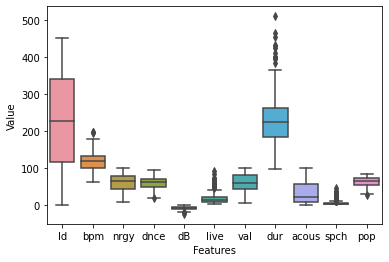

In [ ]:
#Boxplot without Year 
#sns.boxplot(data=reg_train.drop(['title', 'artist', 'top genre','year', "Id"], axis=1))
sns.boxplot(data=eda.drop(["year"], axis=1))

plt.xlabel('Features')
plt.ylabel('Value')
plt.show()

This shows us that we likely need to apply scaling to bring dur, spch, bpm and perhaps dB inline with the rest of the features. 

Also, there are many outliers in dur and spch, these need to be adressed as well, we do this via statistical methodology for the removal of outliers.

In [ ]:
# We handle outliers via statistical methods for removal of those deemed non-significant.
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
eda=eda[(np.abs(stats.zscore(eda.select_dtypes(include=numerics))) < 3).all(axis=1)] #statistical removal of outliers

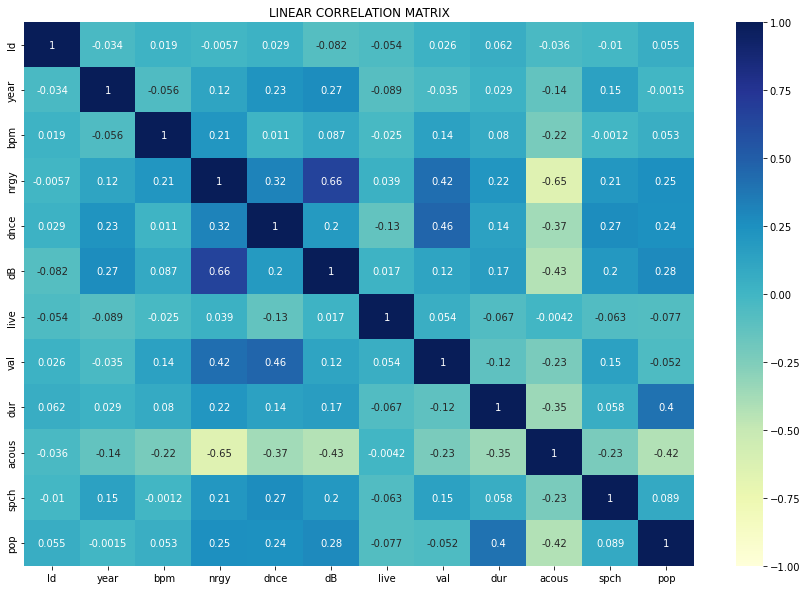

In [ ]:
#linear correlation matrix - heatmap
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(eda.corr(), annot=True, cmap='YlGnBu', vmin=-1, vmax=1, center=0, ax=ax)
plt.title('LINEAR CORRELATION MATRIX')
plt.show()

The correlation matrix shows us features which we might want to consider removing due to high colinearity, such as dB and nrgy (0.66). However, statistically, this was strictly not high enough to justify removal. Therefore, it was decided to keep both features.

## Assessing the need for Data-Scaling in our Methodology


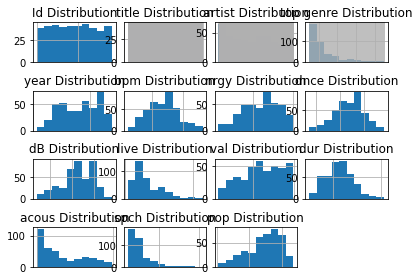

In [ ]:
def draw_histograms(df, variables, n_rows, n_cols): #overkill but it lets us plot everything, including categorical.
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
        plt.tick_params(axis='x',          
                        which='both',      
                        bottom=False,      
                        top=False,         
                        labelbottom=False)
    
    fig.tight_layout()  
    plt.subplots_adjust(wspace=0.1, hspace=0.7)
    plt.show()

draw_histograms(eda, eda.columns, 4, 4)

As the majority of our features are approximately normally distributed, we can use standardscaler to optimise our imported data at a later stage.

Categorical features like title and artist can be ignored, as their evaluation in the histograms is not relevant. 

Top genre has a long tail that we can evaluate as well:


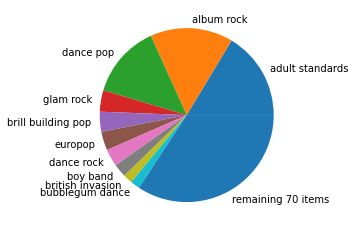

In [ ]:
#finding percentage of each top genre and showing the top 15
plt.axis('off') # disable the axis since they cause label issues
classtr_top10x = eda["top genre"].value_counts() # counts
classtr_top10y = classtr_top10x.head(10) # top 10
if len(classtr_top10x) > 10: #pie chart category splits for the remaining
    classtr_top10y['remaining {0} items'.format(len(classtr_top10x) - 10)] = sum(classtr_top10x[10:])
classtr_top10y.plot(kind='pie') # plot


Top 15 genres comprised >60% of the labels for the entire dataset, overshadowing the remaining 76 genres [labels].

We can check occurances:

In [ ]:
eda['top genre'].value_counts()

adult standards       66
album rock            62
dance pop             55
glam rock             16
brill building pop    15
                      ..
british dance band     1
drone folk             1
bow pop                1
australian rock        1
alternative rock       1
Name: top genre, Length: 80, dtype: int64

This makes stratified splits impossible. Alternative methods to deal with this exist - such as not having unseen labels in the test set. This will be used partially, however - for the classification task we will simply remove the singular occurances as our approach for this task.

In [ ]:
eda2 = eda.loc[eda.duplicated(subset='top genre', keep=False), :]
eda2['top genre'].value_counts()

adult standards         66
album rock              62
dance pop               55
glam rock               16
brill building pop      15
europop                 14
dance rock              13
boy band                10
bubblegum dance          7
british invasion         7
deep adult standards     6
disco                    6
barbadian pop            6
eurodance                6
art rock                 6
british soul             5
soft rock                5
pop                      5
doo-wop                  4
classic uk pop           4
atl hip hop              4
classic soul             4
disco house              3
new wave pop             3
chicago rap              2
glam metal               2
celtic rock              2
blues rock               2
g funk                   2
merseybeat               2
permanent wave           2
country rock             2
classic rock             2
chicago soul             2
british folk             2
belgian pop              2
canadian pop             2
a

Uniques removed, this approach will be used in the following section.

Finally we look at artist duplication in the data:

In [ ]:
eda['artist'].value_counts()

Elton John         9
ABBA               7
Queen              7
Rihanna            5
Whitney Houston    5
                  ..
Van Halen          1
Paul Young         1
Keri Hilson        1
Four Tops          1
*NSYNC             1
Name: artist, Length: 303, dtype: int64

Majority of artists only appear once. Few appear very often. This skews the data somewhat. Out of precaution we will remove this column for this reason, and we can use feature selection later to justify this choice.

# Classification Report

##Initial Steps.

###  Importing data

In [ ]:
def class_load(): #function to load classification data
    classtr = pd.read_csv("CS98XClassificationTrain.csv", low_memory=False)
    classte = pd.read_csv("CS98XClassificationTest.csv", low_memory=False)
    return classtr, classte

### Cleaning

In [ ]:
# Load data and clean it, removing na and also removing duplicates.
class_train, class_test = class_load()  # load data
class_train = class_train.loc[class_train.duplicated(subset='top genre', keep=False), :]
class_train = class_train.dropna(how="any").copy()  # drop irrelevant columns + reset index (or not)

# Split data into X and y plus add in test set
X = class_train.drop(columns=["top genre", "Id"])  
y = class_train["top genre"]

# make sure our import didn't miss anything
class_train.isna().any().any() #check for NA's in the dataset entirely

False

Before we can do feature selection, we need to encode our data because of the categorical features - we use OrdinalEncoder and LabelEncoder for this. We also scale our data.

In [ ]:
# removal of columns that we felt were too unique, or irrelevant (such as Id)
class_train_dropped = class_train.drop(columns=["title", "artist", "Id"])
class_test_dropped = class_test.drop(columns=["title", "artist", "Id"])

#handling outliers:
class_train_dropped=class_train_dropped[(np.abs(stats.zscore(class_train_dropped.select_dtypes(include=numerics))) < 3).all(axis=1)] #statistical removal of outliers
class_test_dropped=class_test_dropped[(np.abs(stats.zscore(class_test_dropped.select_dtypes(include=numerics))) < 3).all(axis=1)] #statistical removal of outliers

# removal of uniques again
class_train_dropped = class_train_dropped.loc[class_train_dropped.duplicated(subset='top genre', keep=False), :]

# maybe need to drop for xgb
#class_train_dropped = class_train.drop(columns=["top genre"])

### Encoding and Scaling

In [ ]:
# Label Encoder
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(class_train_dropped["top genre"])

# Ordinal Encoder
ode = OrdinalEncoder()
X_train_ode = ode.fit_transform(class_train_dropped.drop(columns=["top genre"]))
X_test_ode = ode.fit_transform(class_test_dropped)

# Scaler
std_scaler = StandardScaler() # scaling the newly encoded sets
X_train_scale_ode = std_scaler.fit_transform(X_train_ode)
X_test_scale_ode = std_scaler.fit_transform(X_test_ode)

# One split without encoding
y_noenc = class_train_dropped["top genre"]
X_train_noenc, X_validation_noenc, y_train_noenc, y_validation_noenc = train_test_split(class_train_dropped, y, stratify=y)

# One final split with encoding
X_train, X_validation, y_train, y_validation = train_test_split(X_train_scale_ode, y, stratify=y)


### Feature Selection Justification

We dropped some features earlier, here we justify that they have not made a major difference to our model because the maximum number of features that can explain the most variation is always prefered so the uniqueness of Id & title are non-factors for our problem and whilst artist can be duplicated - it is too rare for this to matter statistically as we establish:

Classification accuracy without selecting features: 0.363
Classification accuracy after univariate feature selection: 0.385


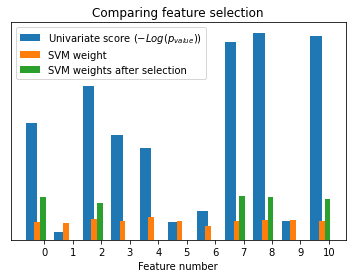

In [ ]:
plt.figure(1)
plt.clf()
X_indices = np.arange(X_train_scale_ode.shape[-1])

selector = SelectKBest(f_classif, k=5)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices - 0.45, scores, width=0.4, label=r"Univariate score ($-Log(p_{value})$)")

clf = make_pipeline(MinMaxScaler(), LinearSVC(dual=False, max_iter=10000, C=1))
clf.fit(X_train, y_train)
print("Classification accuracy without selecting features: {:.3f}".format(clf.score(X_validation, y_validation)))

svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
svm_weights /= svm_weights.sum()
plt.bar(X_indices - 0.25, svm_weights, width=0.2, label="SVM weight")

clf_selected = make_pipeline(SelectKBest(f_classif, k=5), MinMaxScaler(), LinearSVC())
clf_selected.fit(X_train, y_train)
print("Classification accuracy after univariate feature selection: {:.3f}".format(clf_selected.score(X_validation, y_validation)))

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

plt.bar(
    X_indices[selector.get_support()] - 0.05,
    svm_weights_selected,
    width=0.2,
    label="SVM weights after selection",
)

plt.title("Comparing feature selection")
plt.xlabel("Feature number")
plt.yticks(())
x = [0,1,2,3,4,5,6,7,8,9,10]
plt.xticks(x)
plt.axis("tight")
plt.legend(loc="upper left")
plt.show()

The outcome of the above graph shows which features are most important to keep from the ones we had initially chosen to analyse.
Therefore, we will remove the least significant ones (1,5,6,9; ) and proceed with the rest. Therefore, we recreate our sets:

In [ ]:
list(class_train_dropped.columns.values)
# So we remove bpm, live, val and spch.

# Then we need to redo our train/test sets:
# removal of columns that we felt were too unique, or irrelevant (such as Id)
class_train_dropped = class_train.drop(columns=["title", "artist", "Id"])
class_test_dropped = class_test.drop(columns=["title", "artist", "Id"])

# removal of columns that we later identified to be insignificant in feature selection analysis.
class_train_dropped = class_train_dropped.drop(columns=["bpm", "live", "val", "spch"])
class_test_dropped = class_test_dropped.drop(columns=["bpm", "live", "val", "spch"])

#handling outliers:
class_train_dropped=class_train_dropped[(np.abs(stats.zscore(class_train_dropped.select_dtypes(include=numerics))) < 3).all(axis=1)] #statistical removal of outliers

# removal of uniques again
class_train_dropped = class_train_dropped.loc[class_train_dropped.duplicated(subset='top genre', keep=False), :]
# maybe need to drop for xgb
#class_train_dropped = class_train.drop(columns=["top genre"])

# Label Encoder
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(class_train_dropped["top genre"])


# Ordinal Encoder
ode = OrdinalEncoder()
X_train_ode = ode.fit_transform(class_train_dropped.drop(columns=["top genre"]))
X_test_ode = ode.fit_transform(class_test_dropped)
# Scaler

std_scaler = StandardScaler() # scaling the newly encoded sets
X_train_scale_ode = std_scaler.fit_transform(X_train_ode)
X_test_scale_ode = std_scaler.fit_transform(X_test_ode)

# One split without encoding
y_noenc = class_train_dropped["top genre"]
X_train_noenc, X_validation_noenc, y_train_noenc, y_validation_noenc = train_test_split(class_train_dropped, y, stratify=y)

# One final split with encoding
X_train, X_validation, y_train, y_validation = train_test_split(X_train_scale_ode, y, stratify=y)


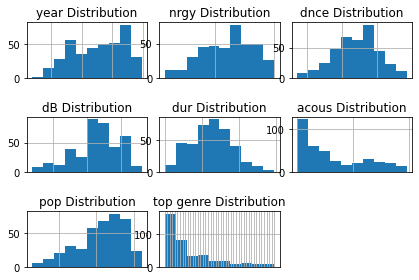

In [ ]:
draw_histograms(class_train_dropped, class_train_dropped.columns, 3, 3)

## Preliminary Algorithm Viability Evaluation via PyCaret

Using PyCaret with the same intent, we applied it to our classification dataset.

In [ ]:
# CatBoost can take quite long to compute on PyCaret (30min+)
from pycaret.classification import *

classification = setup(data=class_train_dropped, target="top genre", numeric_features=["dB"],
                       verbose=False, train_size=0.80, silent=True, data_split_stratify=True)

best_model_eval = compare_models(sort="Accuracy")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.3912,0.0,0.1319,0.2003,0.2605,0.2712,0.2945,0.020
rf,Random Forest Classifier,0.3691,0.0,0.1468,0.2254,0.2723,0.2603,0.2741,0.628
et,Extra Trees Classifier,0.3628,0.0,0.1304,0.2240,0.2709,0.2554,0.2677,0.468
catboost,CatBoost Classifier,0.3526,0.0,0.1329,0.2239,0.2655,0.2480,0.2600,19.968
lightgbm,Light Gradient Boosting Machine,0.3466,0.0,0.1252,0.2326,0.2664,0.2449,0.2553,0.816
lda,Linear Discriminant Analysis,0.3399,0.0,0.1100,0.2143,0.2559,0.2349,0.2457,0.016
gbc,Gradient Boosting Classifier,0.3209,0.0,0.1094,0.2352,0.2641,0.2268,0.2333,7.747
lr,Logistic Regression,0.3175,0.0,0.1154,0.2068,0.2435,0.2092,0.2194,1.398
knn,K Neighbors Classifier,0.3144,0.0,0.1147,0.2059,0.2439,0.2044,0.2132,0.124
nb,Naive Bayes,0.3016,0.0,0.1116,0.2319,0.2543,0.2084,0.2145,0.029


CatBoost was once again consistently in the [top 3 performers](https://i.imgur.com/YCbCAPc.png), but ridge and LDA performed equally well - so we used CatBoost, LDA and ridge regression as our chosen techniques for this problem whilst focusing on the gradient booster CatBoost ultimately. Much like principal component analysis (PCA), LDA also aims to look for linear combinations of variables which best explain the data. Functionally, the methodology behind LDA makes it an incredible tool to apply to this classification problem as it is designed to analyse these types of problems in particular.

### Creating tuned models for all 3 techniques.

Once more, we assess the results of our PyCaret best model.

In [ ]:
#Warning - this can take very (very!!!!!!!!) long.
#The classification task takes incredibly long, I would reduce iteration to 1 if just testing the code.

best_model = tune_model(best_model_eval, n_iter = 100)  # best model; just incase this one is not one of our chosen ones

catboost = create_model("catboost")
catboost_model = tune_model(catboost, n_iter = 100) # tuned catboost model

lda = create_model("lda")
lda_model = tune_model(lda, n_iter = 100) # tuned lasso model

ridge = create_model("ridge")
ridge_model = tune_model(ridge, n_iter = 100) # tuned ridge model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.3125,0.0,0.1000,0.1438,0.1940,0.1852,0.2037
1,0.3125,0.0,0.1000,0.1417,0.1939,0.1852,0.2019
2,0.3226,0.0,0.1056,0.2121,0.2373,0.1780,0.1996
3,0.4194,0.0,0.1333,0.2159,0.2841,0.2972,0.3201
4,0.3871,0.0,0.1222,0.2054,0.2642,0.2554,0.2798
5,0.3871,0.0,0.1314,0.2007,0.2642,0.2582,0.2775
6,0.3226,0.0,0.1167,0.1705,0.2177,0.1963,0.2179
7,0.4194,0.0,0.1529,0.2034,0.2731,0.3077,0.3342
8,0.2903,0.0,0.1000,0.1380,0.1865,0.1538,0.1669
9,0.3548,0.0,0.1222,0.1788,0.2364,0.2346,0.2526


### Predicting and exporting the test sets using PyCarets tuned models.

The tuned models were again exported so that we could evaluate them via Kaggle as the inbuilt metrics of the tuned models are obscured to us by PyCaret.

In [ ]:
pycaret_bestmodel_predictions = predict_model(best_model_eval, data=class_test)
pycaret_catboost_predictions = predict_model(catboost_model, data=class_test)
pycaret_lda_predictions = predict_model(lda_model, data=class_test)
pycaret_ridge_predictions = predict_model(ridge_model, data=class_test)

In [ ]:
pycaret_regression = [pycaret_bestmodel_predictions, pycaret_catboost_predictions, pycaret_lda_predictions, pycaret_ridge_predictions]
pycaret_regression_dict = {1:"pycaret_bestmodel_predictions", 2: "pycaret_catboost_predictions", 3: "pycaret_lda_predictions", 4: "pycaret_ridge_predictions"}
i=0
for model in pycaret_regression: # for loop to save all the outputs
    i = i+1
    submission = pd.DataFrame()
    submission["Id"] = model["Id"]
    submission["top genre"] = model["Label"]
    submission.to_csv(f"{pycaret_regression_dict[i]}.csv", index=False)

The Ridge model performed the best in the uploads to Kaggle. However, because we wanted to analyse the performance of CatBoost for both regression and classification tasks, we chose to perfect the CatBoost model.

> Indented block



### Plotting PyCaret Metrics for the chosen Ridge Model

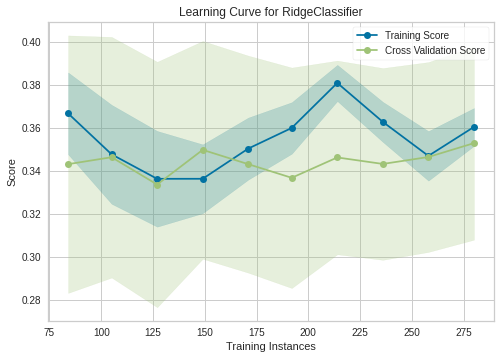

In [ ]:
plot_model(ridge_model, plot = "learning")

Again, we looked at this plot to analyse how well our model is improving across iterations. We theorised that increasing the iterations that we set for PyCaret evaluations and tuning would allow our models be more robust and more accurate, such that it improves the metric (accuracy) outcomes of the model when submitted to kaggle.

## Building Custom & Optimised Classification Models

###XGBoost model with tree.

We used XGBoost because it is known as one of (and for a long time was) the worlds fastest gradient booster and boasted incredibly high accuracies.

In [ ]:
#checking which objective parameter to use
model = XGBClassifier()
model.fit(X_train, y_train)
print(model.objective)
print(class_train_dropped.nunique()) # checking unique count for the num_class param


multi:softprob
year          64
nrgy          88
dnce          75
dB            17
dur          185
acous         90
pop           56
top genre     44
dtype: int64


XGBoost with hyperparameter tuning:

[0]	Test-mlogloss:2.8116
Will train until Test-mlogloss hasn't improved in 50 rounds.
[1]	Test-mlogloss:2.3954
[2]	Test-mlogloss:2.08281
[3]	Test-mlogloss:1.82635
[4]	Test-mlogloss:1.61474
[5]	Test-mlogloss:1.42318
[6]	Test-mlogloss:1.25976
[7]	Test-mlogloss:1.11469
[8]	Test-mlogloss:0.999398
[9]	Test-mlogloss:0.897259
[10]	Test-mlogloss:0.80814
[11]	Test-mlogloss:0.732252
[12]	Test-mlogloss:0.662808
[13]	Test-mlogloss:0.603658
[14]	Test-mlogloss:0.551632
[15]	Test-mlogloss:0.509656
[16]	Test-mlogloss:0.469491
[17]	Test-mlogloss:0.435243
[18]	Test-mlogloss:0.405083
[19]	Test-mlogloss:0.377504
[20]	Test-mlogloss:0.354754
[21]	Test-mlogloss:0.335065
[22]	Test-mlogloss:0.317666
[23]	Test-mlogloss:0.30281
[24]	Test-mlogloss:0.288289
[25]	Test-mlogloss:0.276441
[26]	Test-mlogloss:0.266141
[27]	Test-mlogloss:0.257114
[28]	Test-mlogloss:0.248983
[29]	Test-mlogloss:0.241682
[30]	Test-mlogloss:0.235201
[31]	Test-mlogloss:0.22951
[32]	Test-mlogloss:0.224084
[33]	Test-mlogloss:0.219377
[34]	Test-

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


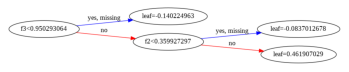

In [ ]:


D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_validation, label=y_train)
params = {
    # Parameters that we are going to tune.
    'max_depth':9,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'multi:softprob',
    'eval_metric':'mlogloss',
    'num_class': 44}

num_boost_round = 50000 # more is merrier
xg_class2 = xgb.train(
    params,
    D_train,
    num_boost_round=num_boost_round,
    evals=[(D_train, "Test")],
    early_stopping_rounds=50)

preds = xg_class2.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])
precision = precision_score(y_validation, best_preds, average='macro')
recall = recall_score(y_validation, best_preds, average='macro')
accuracy = accuracy_score(y_validation, best_preds)
print(str(f"Precision:{precision:.2f}"))
print(str(f"Recall:{recall:.2f}"))
print(str(f"Accuracy:{accuracy:.2f}"))

xgb.plot_tree(xg_class2,num_trees=5,rankdir='LR')
plt.show()

Here it is visible how gradient booster XGBoost works within our classification task, with an impressive accuracy of over 90%. Each leaf node has a probability attached to it which can be calculated from:

In [ ]:
# print(1 / (1 + np.exp(-1 * INSERT_NUMBER_HERE)))
print(1 / (1 + np.exp(-1 * 0.922413051))) # one example number from our tests
# This will give a probability that the node will take this route in the gradient boosting algorithms run.

0.7155335262345708


In [ ]:
# Exporting predictions:
xgboost_testmatrix = xgb.DMatrix(X_test_scale_ode)
predictions_xgb= xg_class2.predict(xgboost_testmatrix)
best_predictions = np.asarray([np.argmax(line) for line in predictions_xgb])

predictions_xgb_invert = best_predictions.ravel()
predictions_xgb_inverted = labelencoder.inverse_transform(predictions_xgb_invert)

submission_class = pd.DataFrame()
submission_class["Id"] = class_test["Id"]
submission_class["top genre"] = predictions_xgb_inverted
submission_class.to_csv(f"Classification_XGB.csv",index=False)

The XGBoost model was not as good as we had hoped, most likely due to encoding issues - this would hopefully be rectified by catboost.

### Ridge Classifier

Ridge Classifier is similar to LDA, but functions using different loss penalties (L2) in a one-vs-rest manner during multiclass tasks and is similar to Least-Squares Support Vector Machine algorithms and their [metric] outcomes.


In [ ]:
ridge_cv_model = RidgeCV(alphas = np.random.randint(0,10,1), cv = 10).fit(X_train,y_train)
ridge_tuned = Ridge().set_params(alpha = ridge_cv_model.alpha_).fit(X_train,y_train)
score = ridge_tuned.score(X_validation, y_validation)
print("Score: ", score)


Score:  0.10460379628496463


Again, the result is worse than during the pycaret testing - it is likely this is because of the encoding, and that the test runs with OneHotEncoding should have been kept because they allowed for more accurate models to be constructed but reversing their encoding for upload to kaggle was too difficult.

### LDA Classifier

We used the LDA classifier (with grid search) as one method for the classification task, since it boasted high accuracy in the tuned models.

In [ ]:
lda_cv_model = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto").fit(X_train,y_train)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=30)
grid = dict()
grid['solver'] = ['svd', 'lsqr', 'eigen']
search = GridSearchCV(lda_cv_model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results = search.fit(X_train, y_train)
print('Mean Accuracy: %.3f' % results.best_score_)

Mean Accuracy: 0.308


Since the outcome was quite poor, we did not submit predictions for this either.

### CatBoost Classifier

Because we established in PyCaret that CatBoost was one of the the best performing classifiers; we used Optuna to identify optimal parameters around which we would perform our inbuilt pseudo-gridsearch (via earlystopping best model adoption).

Once more, so that we can establish the viability of CatBoost as a ML algorithm for both classification and regression tasks, we chose to use it as the final model again so that we could cross compare results and efficacy for each task.

Moreover, because we are open to the idea that GridSearching and hyperparameter tuning in general could fall short to random parameter setting, we also allowed for random strength variable to be used again.

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")

# this takes extremely long on cloud services, to test code replaced iterations & trials with a lower number
train_pool = Pool(X_train, y_train)  # create training pool from X y
validate_pool = Pool(X_validation, y_validation)  # create validation pool from X y

def objective(trial):
    param = {  # params that we can optimise on, for CatBoost in particular 
        "objective": trial.suggest_categorical("objective", ["MultiClass", "MultiClassOneVsAll"]),
        "learning_rate": trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 22, 7),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli"]),
        "random_strength": trial.suggest_int("random_strength", 0, 100),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
    }

    if param["bootstrap_type"] == "Bayesian":  # conditional params for bayesian and bernoulli bootstraps
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_uniform("subsample", 0.1, 1)

    model = catboost.CatBoostClassifier(**param, iterations=500)  # iterations and classifier initialisation
    model.fit(train_pool, eval_set=validate_pool, verbose=0, early_stopping_rounds=100)  # fitting the model

    preds = model.predict(X_validation)  # predictions on validations set
    accuracy = accuracy_score(y_validation, preds)  # get accuracy

    return accuracy

study = optuna.create_study(direction="maximize")  # Initialise Optuna
study.optimize(objective, n_trials=2000, show_progress_bar=True)  # set study params

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Best Score: {}".format(trial.value))
print("  Best Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-02-20 20:38:58,426] A new study created in memory with name: no-name-0fc22ebf-49ba-469a-b3ae-6abd94799567
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/3 [00:00<?, ?it/s]

[I 2022-02-20 20:39:00,483] Trial 0 finished with value: 0.37755102040816324 and parameters: {'objective': 'MultiClassOneVsAll', 'learning_rate': 0.00204182836661469, 'colsample_bylevel': 0.07693932523274942, 'max_depth': 10, 'l2_leaf_reg': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'random_strength': 42, 'od_type': 'Iter', 'bagging_temperature': 9.750515643322421}. Best is trial 0 with value: 0.37755102040816324.
[I 2022-02-20 20:39:01,463] Trial 1 finished with value: 0.37755102040816324 and parameters: {'objective': 'MultiClass', 'learning_rate': 0.13698771410697874, 'colsample_bylevel': 0.0529826048863304, 'max_depth': 2, 'l2_leaf_reg': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'random_strength': 4, 'od_type': 'IncToDec', 'bagging_temperature': 9.967880706348712}. Best is trial 0 with value: 0.37755102040816324.
[I 2022-02-20 20:39:01,908] Trial 2 finished with value: 0.35714285714285715 and parameters: {'objective': 'MultiClass', 'learning_rate': 

Creating a custom CatBoost EarlyStop Model, mainly because gridsearching with a label quantity of 20% the size of our train set would innately cause issues in the integrated test split - we can use the Early Stop model as a pseudo-gridsearch, using the best model to move forward.

In [ ]:
#need to split this section or it just causes colab to crash, the joys of cloud services
train_pool = Pool(X_train, y_train)  # create training pool from X y
validate_pool = Pool(X_validation, y_validation)  # create validation pool from X y

#take params from optuna
iterations_x = 5000  # iterations
l2_leaf_reg_x = 15  # l2 leaf regulation parameter
depth_x = 10  # tree depth
grow_policy_x = "Depthwise"  # tree growth strategy/method (can use Lossguide too, probably the better one)
learning_rate_x = 0.32045007934720904
colsample_bylevel_x = 0.0749379668157421
bootstrap_type_x = "Bernoulli"
params = {"iterations": iterations_x,
          "learning_rate": learning_rate_x,
          "eval_metric": metrics.Accuracy(),
          "use_best_model": False,
          "l2_leaf_reg": l2_leaf_reg_x,
          "depth": depth_x,
          "grow_policy": grow_policy_x,
          "colsample_bylevel": colsample_bylevel_x,
          "bootstrap_type" : bootstrap_type_x
          }

earlystop_params = params.copy()  # copy paramaters from base
earlystop_params.update({  # update params with earlystop parameters
    "od_type": "Iter",  # overfitting detector method
    "od_wait": 40})  # number to detect before method kicks in
print(f"Current Parameters:\n {earlystop_params}\n")
earlystop_model = CatBoostClassifier(**earlystop_params)  # initialise classifier
earlystop_model.fit(train_pool, eval_set=validate_pool)  # fit ES model

best_model_params = params.copy()  # copy params
best_model_params.update({"use_best_model": True})  # update params with use best model parameter
print(f"Current Parameters:\n {best_model_params}\n")
best_model = CatBoostClassifier(**best_model_params)  # initialise classifier
best_model.fit(train_pool, eval_set=validate_pool)  # fit best model

Next we adopt the best parameters from our CatBoost GridSearch and predict on the training set to ascertain metrics.

In [ ]:
print("\nSimple model validation accuracy: {:.4}".format(
    accuracy_score(y_validation,
                   earlystop_model.predict(X_validation))))  # print accuracy score of early stop simple model
simp = accuracy_score(y_validation,
                      earlystop_model.predict(X_validation))  # save the scores for use in output file names.

print("Best model validation accuracy: {:.4}\n".format(
    accuracy_score(y_validation, best_model.predict(X_validation))))  # print accuracy score for best model
best = accuracy_score(y_validation, best_model.predict(X_validation))  # save the scores for use in output file names.


NameError: ignored

Now we make a prediction on the test set and export it to a CSV for upload to Kaggle.
We chose to create submission files for the CatBoost model only, as it was the best model based on the metrics and also because it consistently placed first in the PyCaret "best model" search.

In [ ]:
submission = pd.DataFrame()
submission["Id"] = class_test["Id"]
submission["top genre"] = earlystop_model.predict(class_test)
submission.to_csv(f"Accuracy is_{simp:.2f}_ES_{iterations_x}_{l2_leaf_reg_x}_{depth_x}_{grow_policy_x}.csv",
                  index=False)

submission = pd.DataFrame()
submission["Id"] = class_test["Id"]
submission["top genre"] = best_model.predict(class_test)
submission.to_csv(f"Accuracy is_{best:.2f}_BP_{iterations_x}_{l2_leaf_reg_x}_{depth_x}_{grow_policy_x}.csv",
                  index=False)

## Classification Problem Result

Ultimately, Catboost performed much better than anticipated in the custom model, achieving the highest score on Kaggle for the first 2 weeks of submissions (team name IreneDaoNFTSellers).

#Regression Report

##Dataset Imports

In [ ]:
def reg_load(): # function to import clean sets
    classtr = pd.read_csv("CS98XRegressionTrain.csv", low_memory=False)
    classte = pd.read_csv("CS98XRegressionTest.csv", low_memory=False)
    return classtr, classte

In [ ]:
reg_train, reg_test = reg_load()
reg_train = reg_train.dropna(how="any").copy()
reg_test.fillna("", inplace=True)
X = reg_train.drop(columns=["Id", "title"])  # split data into X and y plus add in test set
X_features = reg_train.columns
y = reg_train["pop"]

# make sure our import didn't miss anything
reg_train.isna().any().any() #check for NA's in the dataset entirely

False

##Train and Validation Sets


In [ ]:
i, a = [1, 1]
while a is not None:  # making sure the test set genres are contained in the training set, so that it doesn't fail due to stratification of the labels being mismatched.
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.80)  # FAILS IF TEST SIZE > ~15%!
    b = y_validation.isin(y_train).value_counts()  # check if genres contained in y are in X
    print(str(f"While labels between sets are mismatched splitting will repeat. Current iteration: {i}"))
    i = i + 1  # counter
    a = b.get(False)  # verification
print(f"Splitting Completed Successfully\n")

While labels between sets are mismatched splitting will repeat. Current iteration: 1
While labels between sets are mismatched splitting will repeat. Current iteration: 2
Splitting Completed Successfully



## Preliminary Algorithm Viablity Evaluation via PyCaret


Our next focus will be on PyCaret for the regression task, which has inbuilt tools that innately handle mixed categorical and integer data and normalises it.

Feature scaling is not required (nor useful) for linear regression (strictly speaking). The only benefit, in theory, is in improvements to our model's accuracy if we use regression models that incorporate regularization such as L1 in Lasso- and L2 in Ridge- Regressors.

PyCaret evaluates various models simultaneously and provides model evaluation metrics such that we could pick from various different techniques to tackle our problem.

One core consideration for using PyCaret was also that it can internally handle missing values, and also performs one-hot encoding seemlessly whilst executing. It also cross-validates internally, making it very robust for an initial "best model" search.

In [ ]:
from pycaret.regression import *

regression = setup(data=X, target="pop", categorical_features=["artist", "top genre"], numeric_features=["dB"],
                   verbose=False, silent=True)
best_model_eval = compare_models(sort="RMSE")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,7.8254,98.9742,9.8033,0.3506,0.1721,0.1414,2.952
gbr,Gradient Boosting Regressor,8.1412,104.1378,10.0173,0.3202,0.1752,0.1467,0.502
et,Extra Trees Regressor,8.1650,103.5144,10.0425,0.3174,0.1752,0.1473,1.181
ridge,Ridge Regression,8.3959,105.5360,10.2388,0.3028,0.1792,0.1509,0.044
rf,Random Forest Regressor,8.3000,109.8638,10.2828,0.2807,0.1803,0.1504,1.077
ada,AdaBoost Regressor,8.3529,109.7027,10.3092,0.2896,0.1812,0.1515,0.412
lightgbm,Light Gradient Boosting Machine,8.3019,111.3974,10.3709,0.2741,0.1801,0.1484,0.256
lasso,Lasso Regression,8.6803,113.1066,10.5783,0.2623,0.1855,0.1571,0.046
en,Elastic Net,8.6841,113.1165,10.5801,0.2625,0.1855,0.1572,0.038
br,Bayesian Ridge,8.7007,115.1748,10.6683,0.2508,0.1878,0.1582,0.189


Across 25 runs, **CatBoost** (a gradient boosting algorithm) was the [highest scorer (yet again)](https://i.imgur.com/5PEJ58r.png) (lowest RMSE), thus ultimately becoming our final model of choice for this regression problem.

We also used **Lasso**  and **Ridge** regression techniques, which often scored in the top 5-10 of the RMSE scores during the PyCaret evaluations to compare methods.

### Creating tuned models for all 3 techniques.
We decided to compare the metrics of tuned PyCaret models for CatBoost, Lasso and Ridge regressors (we also kept a "best model" variable open - in case another regressor performed better than CatBoost such that we could capture their predictions for later comparisons).

In [ ]:
#Warning - this can take very (very!) long.
best_model = tune_model(best_model_eval, n_iter = 50)  # best model for predictions

catboost = create_model("catboost")
catboost_model = tune_model(catboost, n_iter = 50) # tuned catboost model

lasso = create_model("lasso")
lasso_model = tune_model(lasso, n_iter = 50) # tuned lasso model

ridge = create_model("ridge")
ridge_model = tune_model(ridge, n_iter = 50) # tuned ridge model

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,7.4613,90.3845,9.5071,0.6059,0.1810,0.1485
1,8.5392,111.6676,10.5673,0.1926,0.1804,0.1524
2,9.1726,144.6431,12.0268,0.1419,0.2158,0.1751
3,8.2829,105.8606,10.2889,0.2953,0.1873,0.1595
4,9.2259,123.7296,11.1234,0.1485,0.1922,0.1621
5,8.2140,103.5102,10.1740,0.2171,0.1772,0.1411
6,7.4528,78.8848,8.8817,0.4362,0.1563,0.1340
7,7.8941,89.3041,9.4501,0.1626,0.1577,0.1318
8,8.5899,93.9059,9.6905,0.4734,0.1610,0.1475
9,8.5318,100.6373,10.0318,0.4517,0.1750,0.1523


### Predicting and exporting the test sets using PyCarets tuned models.

Once the models were tuned, we predicted on our test data and exported all predictions for upload to kaggle.

In [ ]:
pycaret_bestmodel_predictions = predict_model(best_model_eval, data=reg_test)
pycaret_catboost_predictions = predict_model(catboost_model, data=reg_test)
pycaret_lasso_predictions = predict_model(lasso_model, data=reg_test)
pycaret_ridge_predictions = predict_model(ridge_model, data=reg_test)

pycaret_regression = [pycaret_bestmodel_predictions, pycaret_catboost_predictions, pycaret_lasso_predictions, pycaret_ridge_predictions]
pycaret_regression_dict = {1:"pycaret_bestmodel_predictions", 2: "pycaret_catboost_predictions", 3: "pycaret_lasso_predictions", 4: "pycaret_ridge_predictions"}
i=0
for model in pycaret_regression: # for loop to save all the outputs
    i = i+1
    submission = pd.DataFrame()
    submission["Id"] = model["Id"]
    submission["pop"] = model["Label"]
    submission.to_csv(f"{pycaret_regression_dict[i]}.csv", index=False)

### Plotting PyCaret Metrics for the chosen CatBoost Model.


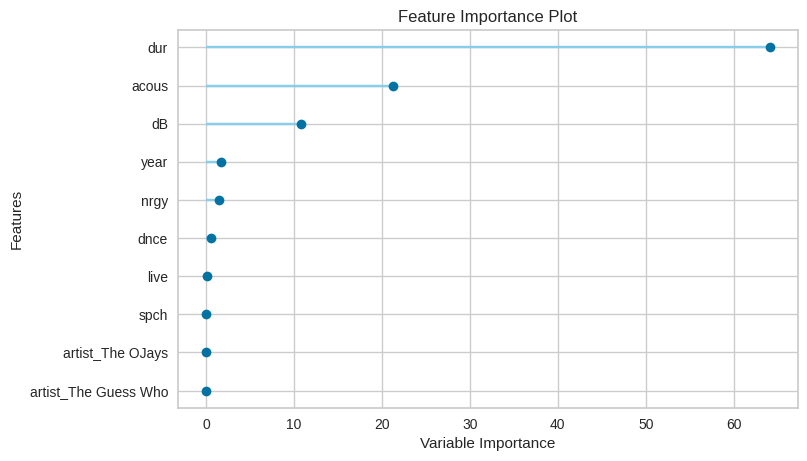

In [ ]:
plot_model(catboost_model, plot = "feature") # or feature_all

This informed us for future customisation of the CatBoost model which features we might want to manually select.

Most ntoable, dur, acous, year and bpm would often be at the top of the list. Duration coming first often was alarming, as we had already dealt with the outliers and the scaling occured internally - but as these precautions were taken, we felt it was justified to leave the feature as is for the time being.

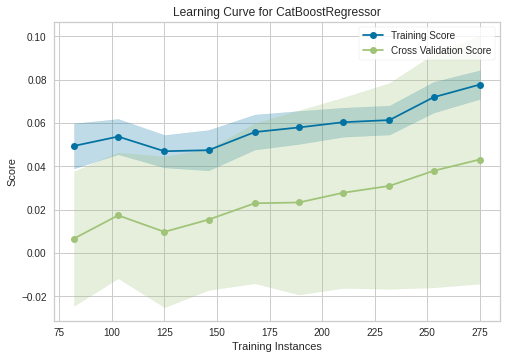

In [ ]:
plot_model(catboost_model, plot = "learning")

This plot showcased the capacity of the model to improve over iterations, as the lines get closer, the implication is that the model improves.

## Rebuilding PyCaret Models as Custom Optimised Models

We now wanted to optimise our chosen best model and alternatives.

### Feature Selection

Our feature selection comprised of variance analysis and scaling of features.

In [ ]:
# Variance check on unchanged data
X.var()

year      278.791365
bpm       633.817649
nrgy      487.953068
dnce      237.306542
dB         12.895317
live      190.646840
val       599.278246
dur      4022.960518
acous     857.313250
spch       31.040406
pop       162.801083
dtype: float64

We proceeded to create a SHAP feature importance graph that would provide more insight. This relies on Shapley values that are used to explain model outputs for machine learning.

While labels between sets are mismatched splitting will repeat. Current iteration: 1
Splitting Completed Successfully



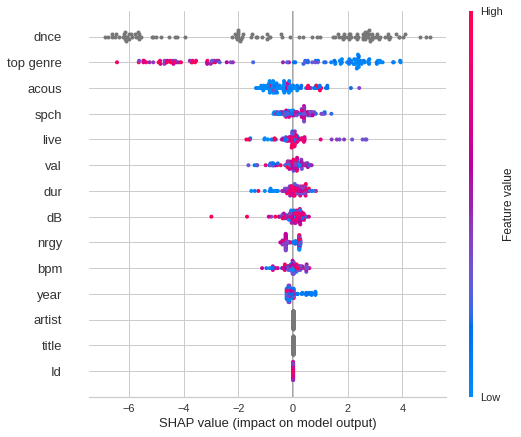

In [ ]:
# have to reload data for label match, manual scaling redone.
reg_train, reg_test = reg_load()
reg_train = reg_train.dropna(how="any").copy()
reg_test.fillna("", inplace=True)
X = reg_train.drop(columns=["pop"])
X_features = reg_train.columns
y = reg_train["pop"]

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
reg_train=reg_train[(np.abs(stats.zscore(reg_train.select_dtypes(include=numerics))) < 3).all(axis=1)] #statistical removal of outliers

i, a = [1, 1]
while a is not None:  # making sure the test set genres are contained in the training set, so that it doesn't fail due to stratification of the labels being mismatched.
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.95)  # FAILS IF TEST SIZE > ~15%!
    b = y_validation.isin(y_train).value_counts()  # check if genres contained in y are in X
    print(str(f"While labels between sets are mismatched splitting will repeat. Current iteration: {i}"))
    i = i + 1  # counter
    a = b.get(False)  # verification
print(f"Splitting Completed Successfully\n")

cat_features_indices = np.where(X.dtypes != float)[0]  # tag categorical
train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)  # create training pool from X y
validate_pool = Pool(X_validation, y_validation, cat_features=cat_features_indices)  # create validation pool from X y

loss_function_x= "RMSE"
model = CatBoostRegressor(loss_function=loss_function_x, iterations=50)  # initialise classifier
model.fit(train_pool, eval_set=validate_pool, verbose=False)  # fit model
pred = model.predict(X_validation)

sorted_feature_importance = model.feature_importances_.argsort()  # sort by feature importance
explainer = shap.TreeExplainer(model) # apply SHAP
shap_values = explainer.shap_values(reg_test) # get values from our test set
shap.summary_plot(shap_values, reg_test, feature_names=X_features[sorted_feature_importance]) # plot values based on features

This informed us that dur was not as often the main predictor of the model - but we hypothesised that this was because it was overshadowing the other features. Alternatively, often live, acous and bpm were also of high importance.

It also let us filter out some features like title and artist, for instance.

###Preparing OneHotEncoder (for Lasso and Ridge Regressors) and Scaling Data
The reason for OneHotEncoding is to eliminate categorical values from our sets and the reason for scaling is to normalise our data, particularly the numeric range disparity between, for instance, dB (-24 to -1) and dur (98-511). This should ensure better accuracy of our models(Lasso and Ridge, in particular).

In [ ]:
# data reload is required, no manual scaling this time since we are going to use stdscaler.
reg_train, reg_test = reg_load()
reg_train = reg_train.dropna(how="any").copy()
reg_test.fillna("", inplace=True)
X = reg_train.drop(columns=["pop"])
X_features = reg_train.columns
y = reg_train["pop"]

# split data into X and y plus add in test set for this section
X = reg_train.drop(columns=["Id", "title", "pop", "artist"])  
i, a = [1, 1]
while a is not None:  # making sure the test set genres are contained in the training set, so that it doesn't fail due to stratification of the labels being mismatched.
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.80)  # FAILS IF TEST SIZE > ~15%!
    b = y_validation.isin(y_train).value_counts()  # check if genres contained in y are in X
    print(str(f"While labels between sets are mismatched splitting will repeat. Current iteration: {i}"))
    i = i + 1  # counter
    a = b.get(False)  # verification
print(f"Splitting Completed Successfully\n")

# Pooling Data Splits and Tagging Categorical Indices for CatBoost
cat_features_indices = np.where(X.dtypes != float)[0]  # tag categorical
train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)  # create training pool from X y
validate_pool = Pool(X_validation, y_validation, cat_features=cat_features_indices)  # create validation pool from X y

ohe = OneHotEncoder(sparse=False) # OHE our train and test sets
reg_train_encohe = ohe.fit_transform(reg_train)
reg_test_encohe = ohe.fit_transform(reg_test)
std_scaler = StandardScaler() # scaling the newly encoded sets
reg_train_scale_enc = std_scaler.fit_transform(reg_train_encohe)
reg_test_scale_enc = std_scaler.fit_transform(reg_test_encohe)

X_scl_enc = reg_train_scale_enc  # split data into X and y plus add in test set
y = reg_train["pop"] # ensuring y is unchanged

# RERUN splitting loop but this time we change y sets to y_[1] because we dont want them to interfere with the original y_[0] sets.
i, a = [1, 1] 
while a is not None:  # making sure the test set genres are contained in the training set, so that it doesn't fail due to stratification of the labels being mismatched.
    X_train_enc, X_validation_enc, y_train1, y_validation1 = train_test_split(X_scl_enc, y, train_size=0.80)  # FAILS IF TEST SIZE > ~20%! (mostly for classification problem)
    b = y_validation.isin(y_train).value_counts()  # check if genres contained in both
    print(str(f"While labels between sets are mismatched splitting will repeat. Current iteration: {i}"))
    i = i + 1  # counter
    a = b.get(False)  # verification
print(f"Splitting Completed Successfully\n")

While labels between sets are mismatched splitting will repeat. Current iteration: 1
Splitting Completed Successfully

While labels between sets are mismatched splitting will repeat. Current iteration: 1
Splitting Completed Successfully



### Lasso Regressor

Least Absolute Shrinkage Selector Operator (LASSO) was picked as it performed well in the PyCaret evaluation. This linear regression model aims to reduce the impact that less important features have on the regression problem - thus only the most critical features end up impacting the model (functionally; feature selection).

In [ ]:
lasso_cv_model = LassoCV(alphas = np.random.randint(0,1000,100), cv = 10, max_iter = 100000).fit(X_train_enc,y_train)
#feature coefficients are closer to zero the higher the alpha <- should say this for lasso 
lasso_tuned = Lasso().set_params(alpha = lasso_cv_model.alpha_).fit(X_train_enc,y_train)
pred = lasso_tuned.predict(X_validation_enc)
rmse = (np.sqrt(mean_squared_error(y_validation, pred)))  # RMSE
r2 = r2_score(y_validation, pred)  # R-Squared
mae = mean_absolute_error(y_validation, pred)  # MAE
print(f"\nMetrics: ")
print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))
print("MAE: {:.2f}".format(mae))



Metrics: 
RMSE: 13.02
R2: -0.00
MAE: 10.54


### Ridge Regressor

Ridge regression, unlike LASSO, aims to reduce model complexity by coefficient shrinkage, preventing multicolinearity issues - which was another concern we faced early on in the report.


In [ ]:
ridge_cv_model = RidgeCV(alphas = np.random.randint(0,10,1), cv = 10).fit(X_train_enc,y_train)
ridge_tuned = Ridge().set_params(alpha = ridge_cv_model.alpha_).fit(X_train_enc,y_train)
pred = ridge_tuned.predict(X_validation_enc)
rmse = (np.sqrt(mean_squared_error(y_validation, pred)))  # RMSE
r2 = r2_score(y_validation, pred)  # R-Squared
mae = mean_absolute_error(y_validation, pred)  # MAE
print(f"\nMetrics: ")
print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))
print("MAE: {:.2f}".format(mae))


Metrics: 
RMSE: 13.51
R2: -0.08
MAE: 10.81


### CatBoost Regressor

Because we established in PyCaret that CatBoost was the best performing regressor; we used Optuna to identify optimal parameters around which we would perform our inbuilt  gridsearch before we move to compare it to the other two custom models we built.

Further to this, due to how CatBoost handles categorical values - there was no necessity to use the OHE data. 

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")

# THIS SECTION MIGHT REQUIRE RUNTIME REBOOT IF ON COLAB/JUPYTER.
reg_train, reg_test = reg_load()
reg_train = reg_train.dropna(how="any").copy()
reg_test.fillna("", inplace=True)
X = reg_train.drop(columns="pop")
X_features = reg_train.columns
y = reg_train["pop"]

reg_train=reg_train[(np.abs(stats.zscore(reg_train.select_dtypes(include=numerics))) < 3).all(axis=1)] #statistical removal of outliers

i, a = [1, 1]
while a is not None:  # making sure the test set genres are contained in the training set, so that it doesn't fail due to stratification of the labels being mismatched.
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.95)  # FAILS IF TEST SIZE > ~15%!
    b = y_validation.isin(y_train).value_counts()  # check if genres contained in y are in X
    print(str(f"While labels between sets are mismatched splitting will repeat. Current iteration: {i}"))
    i = i + 1  # counter
    a = b.get(False)  # verification
print(f"Splitting Completed Successfully\n")

cat_features_indices = np.where(X.dtypes != float)[0]  # tag categorical
train_pool = Pool(X_train, y_train, cat_features=cat_features_indices) #create pools
validate_pool = Pool(X_validation, y_validation, cat_features=cat_features_indices) #^

def objective(trial):
    param = {  # params that we can optimise on, for CatBoost in particular 
        "objective": trial.suggest_categorical("objective", ["RMSE", "Poisson", "MAE"]),
        "learning_rate": trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 22, 7),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "random_strength": trial.suggest_int("random_strength", 0, 100),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
    }

    if param["bootstrap_type"] == "Bayesian":  # conditional params for bayesian and bernoulli bootstraps
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_uniform("subsample", 0.1, 1)

    model = catboost.CatBoostRegressor(**param, iterations=20000)  # iterations and regressor initialisation
    model.fit(train_pool, eval_set=validate_pool, verbose=0, early_stopping_rounds=100)  # fitting the model

    preds = model.predict(X_validation)  # predictions on validations set
    pred_labels = np.rint(preds)  # (round intergers)
    accuracy = accuracy_score(y_validation, pred_labels)  # get accuracy

    return accuracy


study = optuna.create_study(direction="maximize")  # Initialise Optuna
study.optimize(objective, n_trials=2000, show_progress_bar=True)  # set study params

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Best Score: {}".format(trial.value))
print("  Best Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))



While labels between sets are mismatched splitting will repeat. Current iteration: 1
Splitting Completed Successfully



  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Create custom CatBoost GridSearch Model that is now optimised further by the data gathered from Optuna:

In [ ]:
grid_model = CatBoostRegressor(loss_function="RMSE")  # , task_type="GPU")  #RMSE/MAE Optuna recommends MAE
params = {"iterations": [500,1500,2500],
          # careful with iterations >5k - it can take VERY long to copy params from a distant iteration (if best iter. occurs at e.g. 250 but runs complete to 10,000 then it might time out and just fail).
          "learning_rate": [0.001, 0.01, 0.02, 0.03], # optuna identifed: 0.17133 then 0.00325
          "colsample_bylevel": [0.01, 0.02, 0.03, 0.04, 0.05], # optuna identifed: 0.038 then 0.033
          "depth": [1, 2, 3, 4, 5], # optuna identifed: 2 then 1
          "l2_leaf_reg": [1, 5, 8, 15, 25 , 30], # optuna identifed: 15 then 8
          "boosting_type": ["Plain", "Ordered"], # optuna identifed: Ordered then plain
          "bootstrap_type": ["MVS"], # optuna identifed: MVS then MVS
          "random_strength": [random.randint(0, 99)] # optuna identified: 85 then 20
          }  # Poisson - Only works when training on GPU

GS_results = grid_model.grid_search(params, train_pool, refit=True)  # GridSearch
#print(grid_model.get_all_params())
print(f"\nAfter the grid search these were the best parameters:")
print(f"\nBest Params: ", GS_results["params"])  # print best params

Next we adopt the best parameters from our CatBoost GridSearch and predict on the training set to ascertain metrics.

In [ ]:
pred= grid_model.predict(X_validation)
rmse = (np.sqrt(mean_squared_error(y_validation, pred)))  # RMSE
r2 = r2_score(y_validation, pred)  # R-Squared
mae = mean_absolute_error(y_validation, pred)  # MAE
print(f"\nMetrics: ")
print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))
print("MAE: {:.2f}".format(mae))


Metrics: 
RMSE: 12.25
R2: -0.08
MAE: 10.31


Now we make a prediction on the test set and export it to a CSV for upload to Kaggle.
We chose to create submission files for the CatBoost model only, as it was the best model based on the metrics and also because it consistently placed first in the PyCaret "best model" search.

In [ ]:
submission = pd.DataFrame()
print(reg_test)
submission["Id"] = reg_test["Id"]
submission["pop"] = grid_model.predict(reg_test)
submission.to_csv(f"RMSE_is_{rmse:.2f}_R2_is_{r2:.2f}_MAE_is_{mae:.2f}_GridSearch.csv",
                  index=False)

      Id                                              title  ... acous spch
0    454                                            Pump It  ...     1   18
1    455  Circle of Life - From "The Lion King"/Soundtra...  ...    26    3
2    456             We Are The Champions - Remastered 2011  ...    38    3
3    457                              Insomnia - Radio Edit  ...     6    4
4    458                                This Eve of Parting  ...    18    3
..   ...                                                ...  ...   ...  ...
109  563                                         Candy Shop  ...     3   47
110  564                Dragostea Din Tei - Italian Version  ...     4    3
111  565                          Big Poppa - 2005 Remaster  ...    43   27
112  566                       YMCA - Original Version 1978  ...     6   14
113  567                                 Livin' On A Prayer  ...     8    3

[114 rows x 14 columns]


## Regression Problem Result

Ultimately, CatBoost was the best performing regressor on our dataset and scored 0.48214% Accuracy within a few days of the submissions opening.

It could very likely be improved if it were the sole focus of the report.

Total Report Word Count: 1800 (+-50)

things to include: 
A description of the model and solution that you employed for the final set of predictions.

A justification for why you choose this architecture and solution including: how you came up with the approach, why you selected or modified input variables, explaining what worked and did not work, and what other models were tried.

The report should conclude by reporting your performance in the Kaggle InClass competition.
- Explanation of the difference between the train and test data 
- Relative performance in comparison to other solutions

focus on why we went with each technique and critically assess 